<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis/blob/main/alldata/Replicate_GCP1_main_conclusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data/all_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GCP_data/all_data


In [2]:
!pip uninstall -y gcpdatautils
!pip install git+https://github.com/AvantiShri/gcpdatautils.git

Found existing installation: gcpdatautils 0.1.0.0
Uninstalling gcpdatautils-0.1.0.0:
  Successfully uninstalled gcpdatautils-0.1.0.0
  Cloning https://github.com/AvantiShri/gcpdatautils.git to /tmp/pip-req-build-9edfe02q
  Running command git clone --filter=blob:none --quiet https://github.com/AvantiShri/gcpdatautils.git /tmp/pip-req-build-9edfe02q
  Resolved https://github.com/AvantiShri/gcpdatautils.git to commit b452aabef34c6d45ddc8ce59373f3ab8abede154
  Preparing metadata (setup.py) ... done
  Created wheel for gcpdatautils: filename=gcpdatautils-0.1.0.0-py3-none-any.whl size=6114 sha256=de90ed1341d484d5d639345cfe19dc4eddcb67523c6dc52bdd7581e93d47e18f
  Stored in directory: /tmp/pip-ephem-wheel-cache-2s9bxeac/wheels/fe/f9/b7/d5afa50c9e111dcf3a66edb57f0c2273e54d108591664596b8
Successfully built gcpdatautils


In [3]:
from gcpdatautils import parse_events_html

#download the formal event registry and read the events in
!wget https://global-mind.org/pred_formal.html -O pred_formal.html

included_events = parse_events_html("/content/drive/MyDrive/GCP_data/pred_formal.html", exclude_events_longer_than_days=7)

--2023-12-20 13:55:45--  https://global-mind.org/pred_formal.html
Resolving global-mind.org (global-mind.org)... 162.245.217.130
Connecting to global-mind.org (global-mind.org)|162.245.217.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘pred_formal.html’

pred_formal.html        [ <=>                ] 184.64K  1.13MB/s    in 0.2s    

2023-12-20 13:55:46 (1.13 MB/s) - ‘pred_formal.html’ saved [189067]

Skipping because event is more than 7 days long! 25 Pray for Peace 1999-04-03 20:00:00 1999-05-03 19:01:59
Skipping because redundant with a corresponding 'mean' event:  43 New Year Var 99-00 1999-12-31 09:30:00 2000-01-01 11:29:59
Skipping because event is more than 7 days long! 51 Kursk, 10 days 2000-08-12 07:28:00 2000-08-21 14:29:59
Skipping because redundant with a corresponding 'mean' event:  65 New Year Var 00-01 2000-12-31 09:30:00 2001-01-01 11:29:59
Skipping because event is more than 7 days long! 79 Buddhist Stu

In [4]:
len(included_events)

492

In [5]:
from gcpdatautils import GCPMissingDataError, GCPHdf5DataReader
from collections import defaultdict
import numpy as np
import h5py

gcp_data_reader = GCPHdf5DataReader()

Parsing the bad data file: /usr/local/lib/python3.10/dist-packages/gcpdatautils/resources/rotteneggs.txt
manually correcting 47,2000-01-01 00:00:00,2001-06-31 23:59:59,2222
manually correcting 47,2008-04-25 00:00:00,2008-04-55 23:59:59,1092


In [6]:
from datetime import datetime,timedelta
import numpy as np
import h5py
import traceback
import scipy


def compare_different_calc_approaches(egg_values, blocksizes):
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row

  egg_zscores = (egg_values - 100)/np.sqrt(50)

  pvaltozs_sumthensquare = []
  pvaltozs_squarethensum = []
  for blocksize in blocksizes:
    num_blocks = int((len(egg_zscores) - (len(egg_zscores)%blocksize))/blocksize)
    num_eggs = egg_zscores.shape[-1]
    blockreshaped_eggzscores = egg_zscores[0 : blocksize*num_blocks].reshape(num_blocks, blocksize, num_eggs)

    perblock_peregg_zsums = np.sum(blockreshaped_eggzscores, axis=1)/np.sqrt(blocksize) #shape becomes (num_blocks x num_eggs), nan if any value in the block is nan
    num_nonnan_eggblocks = np.sum(np.isnan(perblock_peregg_zsums)==False, axis=-1) #shape is num_blocks

    #compute p value if we sum across eggs first, then square
    perblock_zsums = np.nansum(perblock_peregg_zsums, axis=1)/np.maximum(np.sqrt(num_nonnan_eggblocks), 1) #shape becomes num_blocks
    pvaltoz_sumthensquare = scipy.stats.norm.ppf(scipy.stats.chi2.cdf(x=np.nansum(np.square(perblock_zsums)), df=np.sum(num_nonnan_eggblocks > 0)))
    pvaltozs_sumthensquare.append(pvaltoz_sumthensquare)

    #compute p value if we square first, then sum across eggs and timesteps
    pvaltoz_squarethensum = scipy.stats.norm.ppf(scipy.stats.chi2.cdf(np.nansum(np.square(perblock_peregg_zsums)),
                                                  df=np.sum(num_nonnan_eggblocks)))
    #the above code sometimes returns cdfs of 1.0, so we will also use the normal approx and take the less significant of the two
    pvaltoz_squarethensum = min(pvaltoz_squarethensum,
                                np.nansum(np.square(perblock_peregg_zsums)-1)/np.sqrt(2*np.sum(num_nonnan_eggblocks)) )
    pvaltozs_squarethensum.append(pvaltoz_squarethensum)

  return pvaltozs_sumthensquare, pvaltozs_squarethensum


BLOCKSIZES = [1]#, 2, 3, 6, 8, 10, 15]
all_pvaltozs_sumthensquare = []
all_pvaltozs_squarethensum = []

control_timeshifts = [-2]#-50, -10, -4, -3, -2, -1, 1, 2, 3, 4, 10, 50]

controls_all_pvaltozs_sumthensquare = dict([(x,[]) for x in control_timeshifts])
controls_all_pvaltozs_squarethensum = dict([(x,[]) for x in control_timeshifts])

surviving_events = [] #in case we encounter missing data errors
#read the data for the events

eventcount = 0

for (event_num, event_name, start_datetime, end_datetime, duration) in included_events[:]:
  eventcount += 1
  print("EVENT COUNT", eventcount)
  print(event_num, event_name, start_datetime, end_datetime, duration)
  try:
    event_data = gcp_data_reader.fetch_data(start_datetime, end_datetime, normalize=True)[0]
    event_pvaltozs_sumthensquare, event_pvaltozs_squarethensum = compare_different_calc_approaches(event_data, BLOCKSIZES)
    print("Event data: Sum then square:", event_pvaltozs_sumthensquare)
    print("Event data: Square then sum:", event_pvaltozs_squarethensum)

    print("For controls...")
    thisevent_control_pvaltozs_sumthensquare = {}
    thisevent_control_pvaltozs_squarethensum = {}
    for control_timeshift in control_timeshifts:
      timeshift = timedelta(seconds=control_timeshift*duration)
      control_starttime = start_datetime + timeshift
      control_endtime = end_datetime + timeshift
      print("Control start and end:", control_starttime, control_endtime)
      control_data = gcp_data_reader.fetch_data(control_starttime, control_endtime, normalize=True)[0]
      pvaltozs_sumthensquare, pvaltozs_squarethensum = compare_different_calc_approaches(control_data, BLOCKSIZES)
      print("Control data: Sum then square:", pvaltozs_sumthensquare)
      print("Control data: Square then sum:", pvaltozs_squarethensum)
      thisevent_control_pvaltozs_sumthensquare[control_timeshift] = pvaltozs_sumthensquare
      thisevent_control_pvaltozs_squarethensum[control_timeshift] = pvaltozs_squarethensum

    all_pvaltozs_sumthensquare.append(event_pvaltozs_sumthensquare)
    all_pvaltozs_squarethensum.append(event_pvaltozs_squarethensum)
    for control_timeshift in control_timeshifts:
      controls_all_pvaltozs_sumthensquare[control_timeshift].append(
          thisevent_control_pvaltozs_sumthensquare[control_timeshift])
      controls_all_pvaltozs_squarethensum[control_timeshift].append(
          thisevent_control_pvaltozs_squarethensum[control_timeshift])
    surviving_events.append((event_num, event_name, start_datetime, end_datetime, duration))
  except GCPMissingDataError as e:
    print("MISSING DATA ERROR!",e)


EVENT COUNT 1
1 Embassy 1998-08-07 07:15:00 1998-08-07 10:14:59 10800.0
Event data: Sum then square: [1.5001853950537507]
Event data: Square then sum: [1.0480112038145037]
For controls...
Control start and end: 1998-08-07 01:15:00 1998-08-07 04:14:59
Control data: Sum then square: [0.049901095628338235]
Control data: Square then sum: [0.33227719040489545]
EVENT COUNT 2
1 Embassy 1998-08-07 07:15:00 1998-08-07 10:14:59 10800.0
Event data: Sum then square: [1.5001853950537507]
Event data: Square then sum: [1.0480112038145037]
For controls...
Control start and end: 1998-08-07 01:15:00 1998-08-07 04:14:59
Control data: Sum then square: [0.049901095628338235]
Control data: Square then sum: [0.33227719040489545]
EVENT COUNT 3
3 Bomb Afghanistan 1998-08-20 17:15:00 1998-08-20 17:44:59 1800.0
Event data: Sum then square: [-0.4119831063396925]
Event data: Square then sum: [0.01841669915636503]
For controls...
Control start and end: 1998-08-20 16:15:00 1998-08-20 16:44:59
Control data: Sum then 

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/gcpdatautils/load_data.py:137: RuntimeWarning: Mean of empty slice
  device_day_means = np.nan_to_num(np.nanmean(full_day_data, axis=0), 100)


Before masking, fraction of nans in raw data is 0.029133597883597883 for 1998-12-16 00:00:00 to 1998-12-16 23:59:59
Found 'rotten egg' entries for device id: 1005 in time range 1998-12-16 00:00:00 to 1998-12-16 23:59:59 (range: 1998-12-10 00:00:00 to 1998-12-17 23:59:59 )
After masking, fraction of nans in raw data is 0.14286044973544973
Event data: Sum then square: [-1.293504183152081]
Event data: Square then sum: [0.18508772015762406]
For controls...
Control start and end: 1998-12-16 19:30:00 1998-12-16 20:29:59
Before masking, fraction of nans in raw data is 0.029133597883597883 for 1998-12-16 00:00:00 to 1998-12-16 23:59:59
Found 'rotten egg' entries for device id: 1005 in time range 1998-12-16 00:00:00 to 1998-12-16 23:59:59 (range: 1998-12-10 00:00:00 to 1998-12-17 23:59:59 )
After masking, fraction of nans in raw data is 0.14286044973544973
Control data: Sum then square: [1.0569635707426652]
Control data: Square then sum: [-1.1985071238093215]
EVENT COUNT 13
13 Vote Impeachment 

num events after dropping events with missing data: 487



Blocksize: 1 seconds
************TEST TYPE: actual
Meta-analysis Z-score if squaring *after* summing: 5.8912140547814404 pval: 1.9168429066240833e-09
Meta-analysis Z-score if squaring *before* summing 1.1762628645488764 pval:  0.1197449251857774
Argmax event for square after summing: ('487', 'September 21', datetime.datetime(2014, 9, 21, 0, 0), datetime.datetime(2014, 9, 21, 23, 59, 59), 86400.0) 3.3323948949835147
Argmax event for square before summing: ('271', 'Obama Acceptance 080828', datetime.datetime(2008, 8, 29, 2, 0), datetime.datetime(2008, 8, 29, 3, 59, 59), 7200.0) 3.274159999443293
Correlation between the two scores: PearsonRResult(statistic=0.10651110366651995, pvalue=0.018715663111093888)


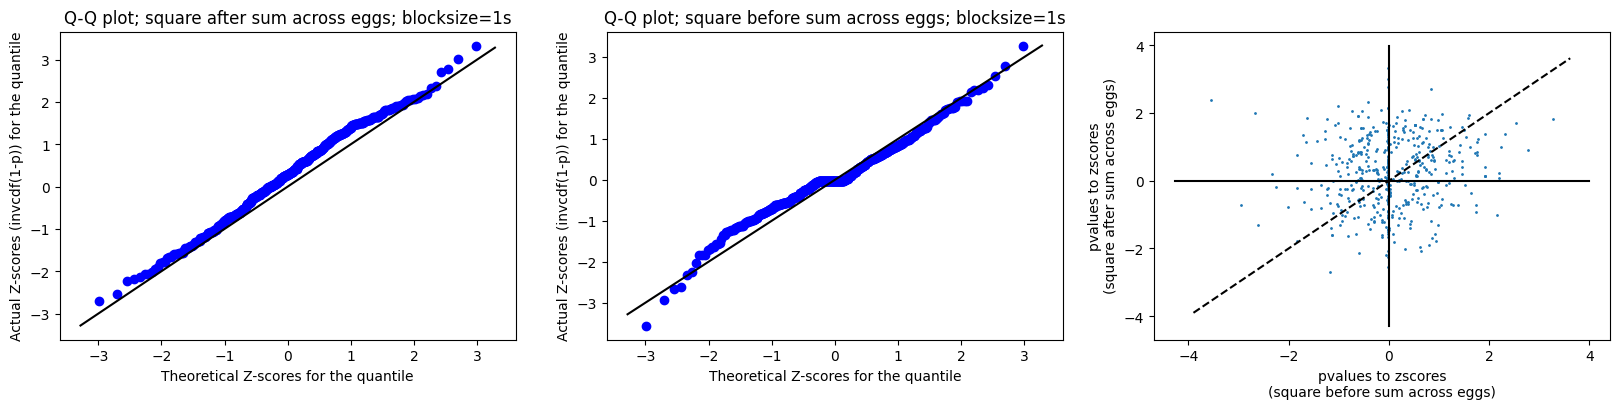

************TEST TYPE: controltimeshift_-2
Meta-analysis Z-score if squaring *after* summing: 0.3141735411835253 pval: 0.3766946185447648
Meta-analysis Z-score if squaring *before* summing 1.5407423633655386 pval:  0.0616897510005201
Argmax event for square after summing: ('434', '12.12.12 Meditation', datetime.datetime(2012, 12, 12, 12, 30), datetime.datetime(2012, 12, 12, 15, 29, 59), 10800.0) 3.6782721397569507
Argmax event for square before summing: ('106', 'Tiger Woods Triumph', datetime.datetime(2002, 4, 14, 18, 22), datetime.datetime(2002, 4, 14, 22, 59, 59), 16680.0) 3.0899698954945283
Correlation between the two scores: PearsonRResult(statistic=0.1221491062960737, pvalue=0.006959387724294442)


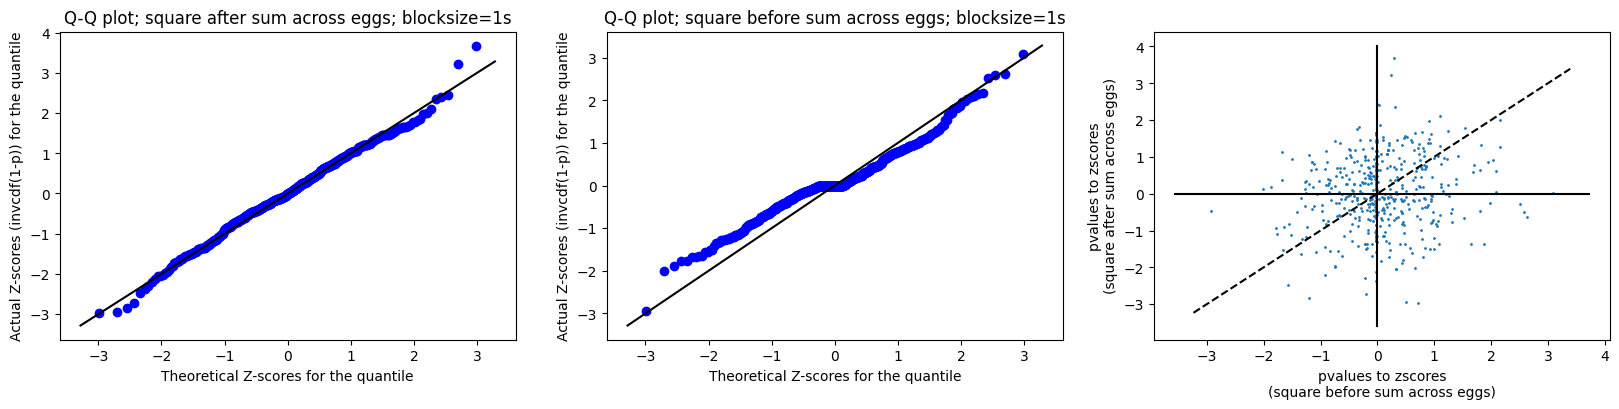

In [7]:
from matplotlib import pyplot as plt

print("num events after dropping events with missing data:", len(surviving_events))

for blocksize_counter, blocksize in enumerate(BLOCKSIZES):
  print("\n\n\nBlocksize:", blocksize, "seconds")

  for (touse_pvaltozs_sumthensquare, touse_pvaltozs_squarethensum, testtype) in (
      [ (all_pvaltozs_sumthensquare, all_pvaltozs_squarethensum, "actual")]
      +[ (controls_all_pvaltozs_sumthensquare[control_timeshift],
          controls_all_pvaltozs_squarethensum[control_timeshift],
          "controltimeshift_"+str(control_timeshift))
         for control_timeshift in control_timeshifts ]):

    print("************TEST TYPE:", testtype)

    for i in range(len(touse_pvaltozs_sumthensquare)):
      if np.isnan(touse_pvaltozs_sumthensquare[i][blocksize_counter]):
        print("Nan warning for event:", surviving_events[i])

    pvaltoz_sumthensquare = [x for x in np.array([x[blocksize_counter] for x in touse_pvaltozs_sumthensquare]) if np.isnan(x)==False]
    pvaltoz_squarethensum = [x for x in np.array([x[blocksize_counter] for x in touse_pvaltozs_squarethensum]) if np.isnan(x)==False]

    metaz_sumthensquare = np.sum(pvaltoz_sumthensquare)/np.sqrt(len(pvaltoz_sumthensquare))
    metaz_squarethensum = np.sum(pvaltoz_squarethensum)/np.sqrt(len(pvaltoz_squarethensum))
    print("Meta-analysis Z-score if squaring *after* summing:", metaz_sumthensquare, "pval:", 1-scipy.stats.norm.cdf(metaz_sumthensquare))
    print("Meta-analysis Z-score if squaring *before* summing", metaz_squarethensum, "pval: ", 1-scipy.stats.norm.cdf(metaz_squarethensum))
    print("Argmax event for square after summing:", surviving_events[np.argmax(pvaltoz_sumthensquare)], np.max(pvaltoz_sumthensquare))
    print("Argmax event for square before summing:", surviving_events[np.argmax(pvaltoz_squarethensum)], np.max(pvaltoz_squarethensum))
    print("Correlation between the two scores:", scipy.stats.pearsonr(pvaltoz_squarethensum, pvaltoz_sumthensquare))

    fig, ax = plt.subplots(ncols=3, figsize=(20,4))
    plt.sca(ax[0])
    scipy.stats.probplot(pvaltoz_sumthensquare, dist=scipy.stats.norm, plot=plt, fit=False)
    plt.plot(plt.xlim(), plt.xlim(), color="black")
    plt.title("Q-Q plot; square after sum across eggs; blocksize="+str(blocksize)+"s")
    plt.xlabel("Theoretical Z-scores for the quantile")
    plt.ylabel("Actual Z-scores (invcdf(1-p)) for the quantile")
    plt.sca(ax[1])
    scipy.stats.probplot(pvaltoz_squarethensum, dist=scipy.stats.norm, plot=plt, fit=False)
    plt.plot(plt.xlim(), plt.xlim(), color="black")
    plt.title("Q-Q plot; square before sum across eggs; blocksize="+str(blocksize)+"s")
    plt.xlabel("Theoretical Z-scores for the quantile")
    plt.ylabel("Actual Z-scores (invcdf(1-p)) for the quantile")
    plt.sca(ax[2])
    plt.scatter(pvaltoz_squarethensum, pvaltoz_sumthensquare, s=1)
    plt.plot(plt.xlim(), plt.xlim(), color="black", linestyle="--")
    plt.plot(plt.xlim(), [0,0], color="black")
    plt.plot([0,0], plt.ylim(), color="black")
    plt.xlabel("pvalues to zscores\n(square before sum across eggs)")
    plt.ylabel("pvalues to zscores\n(square after sum across eggs)")
    plt.show()